# Introduction to Simulation‑Based Inference

Simulation‑based inference (SBI) refers to a collection of Bayesian methods for estimating the posterior distribution of model parameters when the likelihood function is intractable, but synthetic data can be generated. 

SBI tools such as the `sbi` Python package automate the process of learning the mapping from observed data back to model parameters using neural density estimators.

## A quick recap: Bayesian Inference

In this workshop, we focus on the **Bayesian Inference**. Our goal is to calculate the **Posterior** probability distribution—the probability of our parameters ($\theta$) being true given the data ($x$) we observed.

$$P(\theta | x) = \frac{P(x | \theta) \cdot P(\theta)}{P(x)}$$

Where:
* **$\theta$ (Theta):** The parameters we want to infer (e.g., Effective Population Size).
* **$x$:** The observed data (e.g., Site Frequency Spectrum).
* **$P(\theta)$ -- The Prior:** Our initial guess before seeing data (e.g., "$N_e$ is somewhere between 100 and 100,000").
* **$P(x | \theta)$ -- The Likelihood:** The probability of observing data $x$ if the parameters were $\theta$.
* **$P(\theta | x)$ -- The Posterior:** Our updated belief about the parameters after analyzing the data.

## Why SBI?

In many scientific domains, simulators provide high‑fidelity models of complex processes. 

These simulators take parameters 𝜃 as input and produce synthetic data 𝑥. However, the likelihood of observing a particular dataset given a set of parameters is often **mathematically intractable**. 

SBI bypasses this issue by repeatedly simulating data for parameters drawn from a prior distribution and training a neural network to learn the relationship between the data and parameters.

## Algorithms

The `sbi` toolkit implements several families of algorithms:

* **Neural Posterior Estimation (NPE)**: Directly approximates the posterior distribution using neural density estimators.
* **Neural Likelihood Estimation (NLE)**: Learns an approximate likelihood model which is combined with Markov Chain Monte Carlo (MCMC) to sample from the posterior.
* **Neural Ratio Estimation (NRE)**: Estimates the likelihood ratio between parameter values and uses it in an MCMC scheme.

For most tasks in this workshop we will use NPE because it provides an amortized posterior that can be evaluated for many observations without retraining.

## Simple example from the official sbi [documentation](https://sbi.readthedocs.io/en/latest/tutorials/00_getting_started.html): 
Use NPE in SBI to learn a posterior distribution from simulated **parameter–data pairs** and visualize the inferred parameter uncertainty for a simple linear-Gaussian model.

In [95]:
from sbi.inference import NPE
from sbi.analysis import pairplot
import torch
from sbi.utils import BoxUniform
import matplotlib.pyplot as plt

_ = torch.manual_seed(0)

## Define a **prior** and a **simulator**

In this example, we use a Uniform Prior defined in a 3-dimensional parameter space ($\theta_1$, $\theta_2$,$\theta_3$). 

*A uniform prior means every value in that box is equally likely.*

In [96]:
num_dim = 3
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

/var/folders/k5/fxhm2ffn0vz3vy1__6s7lhn80000gp/T/ipykernel_61566/3517217786.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['title'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, ax = pairplot(


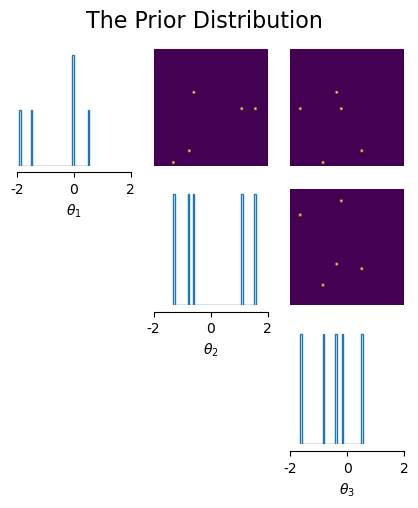

In [97]:
# plot the prior
fig, ax = pairplot(
    prior.sample((5,)) ,
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    title="The Prior Distribution"
)

The simulator in this example is a Linear Gaussian Model, where the data x is simply the parameter $\theta$ plus a constant and some random Gaussian noise.

*In practice, the simulator can be anything that takes parameters and returns simulated data*

In [98]:
def simulator(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

## Neural posterior estimation (NPE)
To run NPE, we need to instatiate a trainer `inference`.

In [99]:
inference = NPE(prior=prior)

Generate 𝜃 and 𝑥 pairs: 𝑥 = simulator(𝜃)

In [101]:
num_simulations = 1000
theta = prior.sample((num_simulations,))
x = simulator(theta)

print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([1000, 3])
x.shape torch.Size([1000, 3])


We can now plot the inputs (θ) versus the outputs (x) of our simulator, and see the relationship the neural network must learn.

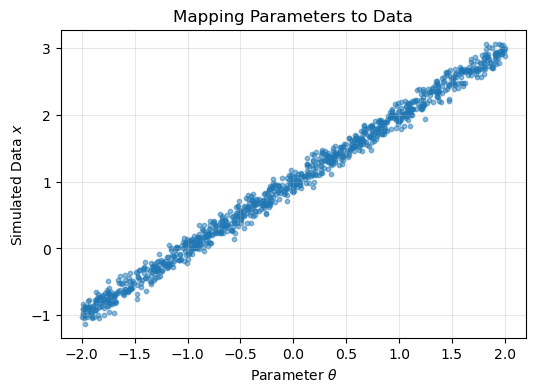

In [102]:
plt.figure(figsize=(6, 4))
plt.scatter(theta[:, 0].numpy(), x[:, 0].numpy(), alpha=0.5, s=10)
plt.xlabel(r"Parameter $\theta$")
plt.ylabel(r"Simulated Data $x$")
plt.title("Mapping Parameters to Data")
plt.grid(True, alpha=0.3)
plt.show()

Pass the simulated data to the inference object, train the density estimator using the paired $\theta$ and x.


 Training neural network. Epochs trained: 95

 Neural network successfully converged after 96 epochs.

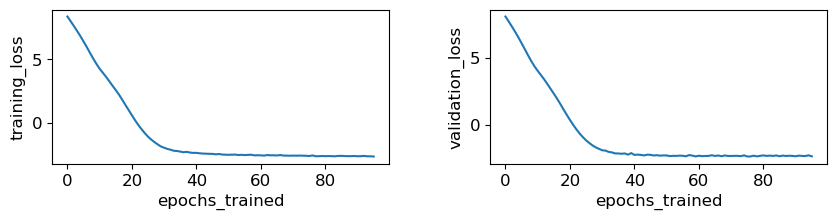

In [103]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

# Plot the loss curve to see the convergence of the training loop
from sbi.analysis import plot_summary

_ = plot_summary(
    inference,
    tags=["training_loss", "validation_loss"],
    figsize=(10, 2),
)

In [104]:
posterior = inference.build_posterior() # build the posterior
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


When we have some observation `x_obs` for which we now want to infer the posterior. Given the observation `x_obs`, we can sample from the posterior *$p(θ|x_{obs})$*:

In [105]:
theta_true = prior.sample((1,)) # ground-truth parameter, we simply sample from the prior here
x_obs = simulator(theta_true) # observed data simulated from the ground-truth parameter
samples = posterior.sample((1000,), x=x_obs)

  0%|          | 0/1000 [00:00<?, ?it/s]

**To infer the posterior distribution from a new observation, we don't need to retrain the model (amortization).**

## Visualize these posterior

Having obtained samples from the posterior, we can now plot them in a pair plot, where we also indicate the ground-truth parameter in orange for reference.


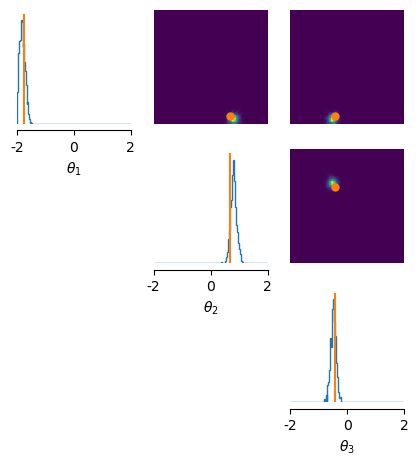

In [106]:
_ = pairplot(
    samples,
    points=theta_true,
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
)

We observe that the posterior samples (blue) are concentrated around the ground-truth parameter (orange). This indicates that the inference procedure has successfully recovered the true parameter from the observed data.

To further validate the quality of the inferred posterior, we can use several methods that diagnose potential issues with the inference procedure, including posterior predictive checks (PPC) and simulation-based calibration (SBC)

## Posterior Predictive Checks (PPC)
The idea is to compare the data generated by the model (using the posterior distribution) to the observed data. If the model fits well, the simulated data should resemble the observed data.

In [107]:
theta_posterior = posterior.sample((10000,), x=x_obs)  # Sample from posterior.
x_predictive = simulator(theta_posterior)  # Simulate data from posterior.

print("Posterior predictives: ", torch.mean(x_predictive, axis=0))
print("Observation: ", x_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

Posterior predictives:  tensor([-0.8078,  1.8007,  0.4992])
Observation:  tensor([[-0.8110,  1.7673,  0.5493]])


We can see that the posterior predictives are roughly centered around the observation.

## Simulation-based calibration (SBC)
SBC used the simulated data to compute the posterior distribution, then checks where the true parameter (θ) falls in the posterior samples (its rank). If the inference is correct, the ranks should follow a uniform distribution.

In [117]:
num_sbc_samples = 100  # choose a number of sbc runs, should be ~100s
prior_samples = prior.sample((num_sbc_samples,))
prior_predictives = simulator(prior_samples)

In [112]:
from sbi.diagnostics import run_sbc

num_posterior_samples = 1_00
ranks, dap_samples = run_sbc(
    prior_samples,
    prior_predictives,
    posterior,
    reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Sampling 100 times (100,) posterior samples.: 100%|██████████| 100/100 [00:01<00:00, 65.48it/s]


Calculating ranks for 100 SBC samples:   0%|          | 0/100 [00:00<?, ?it/s]

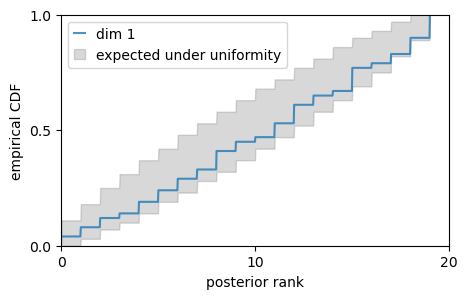

In [113]:
from sbi.analysis.plot import sbc_rank_plot

fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples,
    plot_type="cdf",
    num_bins=20,
    figsize=(5, 3),
)